In [2]:

import os
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, DummyVecEnv
from stable_baselines3.common.monitor import Monitor, load_results
import matplotlib.pyplot as plt
from src import render_model_gym
from datetime import datetime
import importlib
from src import render_model_gym

from src import helpers
from src.definitions import PROJECT_ROOT, enforce_absolute_path

import src.lucy_classes_v1 as lucy
importlib.reload(lucy)

<module 'src.lucy_classes_v1' from 'c:\\GitHub\\training-lucy\\src\\lucy_classes_v1.py'>

In [3]:
# Configuration
n_envs = 7
xml_path = enforce_absolute_path("animals/lucy_v1.xml")


print(f"MuJoCo version: {mujoco.__version__}")

# Verify Lucy model loads
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(f"Lucy model loaded: {model.nq} qpos dims, {model.nv} qvel dims, {model.nu} actuators")
print(f"Observation space will be: {model.nq - 2 + model.nv} dims (qpos[2:] + qvel)")

sim_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
log_dir = f"logs/lucy_v1_standing_{sim_start_time}/"
os.makedirs(log_dir, exist_ok=True)
print(f"Standing log directory: {log_dir}")

MuJoCo version: 3.4.0
Lucy model loaded: 59 qpos dims, 47 qvel dims, 19 actuators
Observation space will be: 104 dims (qpos[2:] + qvel)
Standing log directory: logs/lucy_v1_standing_2026-01-10_09-43/


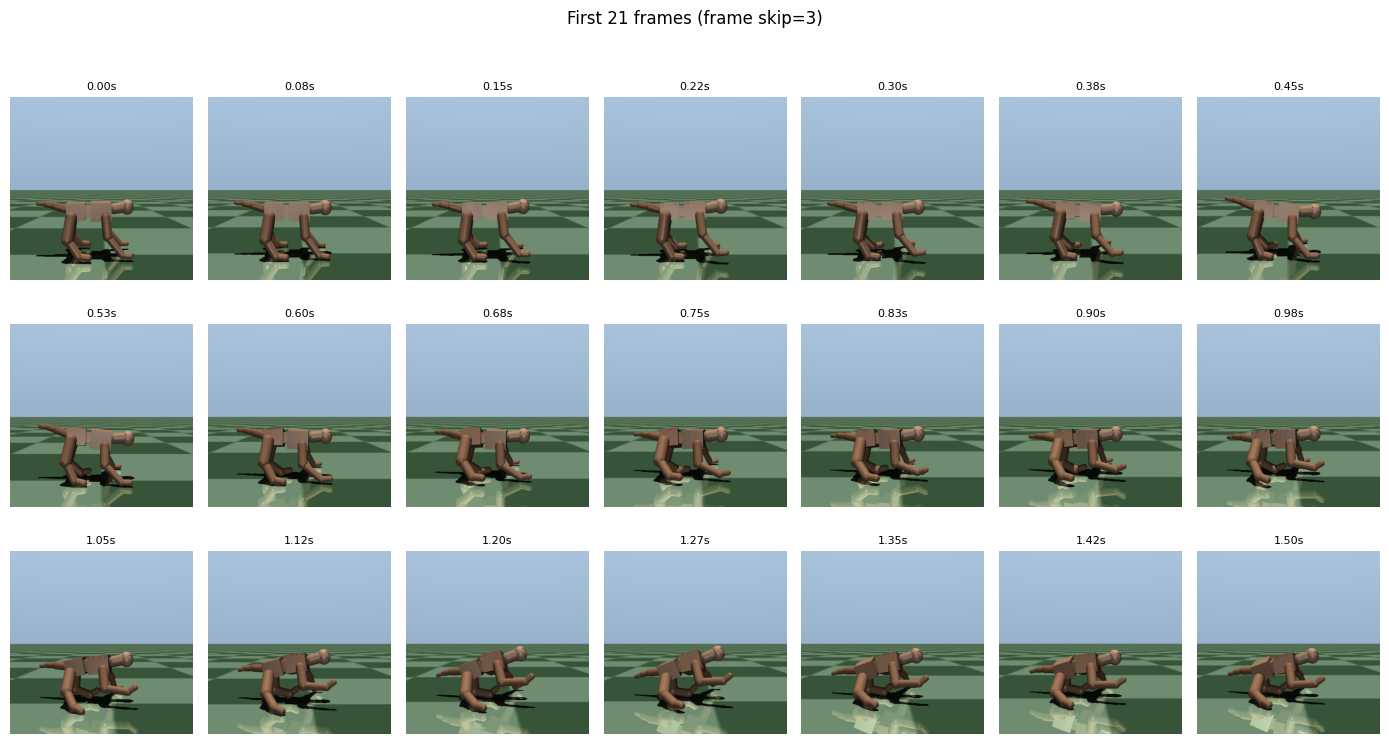

,time,chest_height,forward_velocity,total_height_reward,head_direction_reward,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN
1,0.075,0.191353,0.059617,0.689263,0.086228,-1.692180,-2.949394
2,0.150,0.196881,-0.057236,0.713336,0.085896,-1.672801,-5.903959
3,0.225,0.198889,0.008309,0.723219,0.086383,-1.564895,-8.648212
4,0.300,0.194206,0.058252,0.702123,0.086100,0.376227,-9.462600
5,0.375,0.188996,0.108063,0.688275,0.086764,0.305605,-8.471083
6,0.450,0.181204,0.055530,0.662091,0.088648,2.311004,-3.590414
7,0.525,0.175806,-0.063207,0.630247,0.092365,-1.745919,-0.731240
8,0.600,0.166719,-0.172532,0.567071,0.099253,-1.783772,-0.045537
9,0.675,0.159682,-0.042256,0.533608,0.096965,-1.805098,-1.390648


In [4]:
importlib.reload(lucy)
def make_env(render_mode = 'None', *args, **kwargs):
     return lucy.LucyStandingWrapper(
        lucy.LucyEnv(xml_file=xml_path, render_mode=render_mode, max_episode_seconds = 5),
     )

env = make_env(render_mode="rgb_array")

df = render_model_gym.display_test_env(env, max_frames=21, frame_skip=3, attr_keys=["chest_height", "forward_velocity", "total_height_reward", "head_direction_reward"])
plt.show()
df

In [5]:
standing_vec_env = make_vec_env(
    make_env,
    n_envs=n_envs,
    vec_env_cls=SubprocVecEnv,
    monitor_dir=log_dir,
)
standing_vec_env = VecMonitor(standing_vec_env, log_dir)

print(f"Created {n_envs} parallel standing environments")
print(f"Logging to: {log_dir}")


standing_model = PPO(
    "MlpPolicy",
    standing_vec_env,
    verbose=1,
    device="cpu",
    n_steps=2048,
    batch_size=256,
    n_epochs=5,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,  # Encourage exploration
    learning_rate=4e-4,
    policy_kwargs=dict(
        net_arch=dict(pi=[512, 512], vf=[512, 512])  # Larger network for complex body
    ),
)

# Train for standing (shorter since simpler task)
STANDING_TIMESTEPS = 800_000
print(f"Training standing policy for {STANDING_TIMESTEPS:,} timesteps...")
standing_model.learn(total_timesteps=STANDING_TIMESTEPS)

c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Created 7 parallel standing environments
Logging to: logs/lucy_v1_standing_2026-01-10_09-43/
Using cpu device
Training standing policy for 800,000 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 59.7     |
|    ep_rew_mean     | -53.8    |
| time/              |          |
|    fps             | 2603     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 70.1        |
|    ep_rew_mean          | -43.5       |
| time/                   |             |
|    fps                  | 2297        |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.020465612 |
|    clip_fraction        | 0.306     

In [6]:
standing_model_save_path = os.path.join(PROJECT_ROOT, "trained_models", f"lucy_v1_standing_model_{sim_start_time}")
standing_model.save(standing_model_save_path)

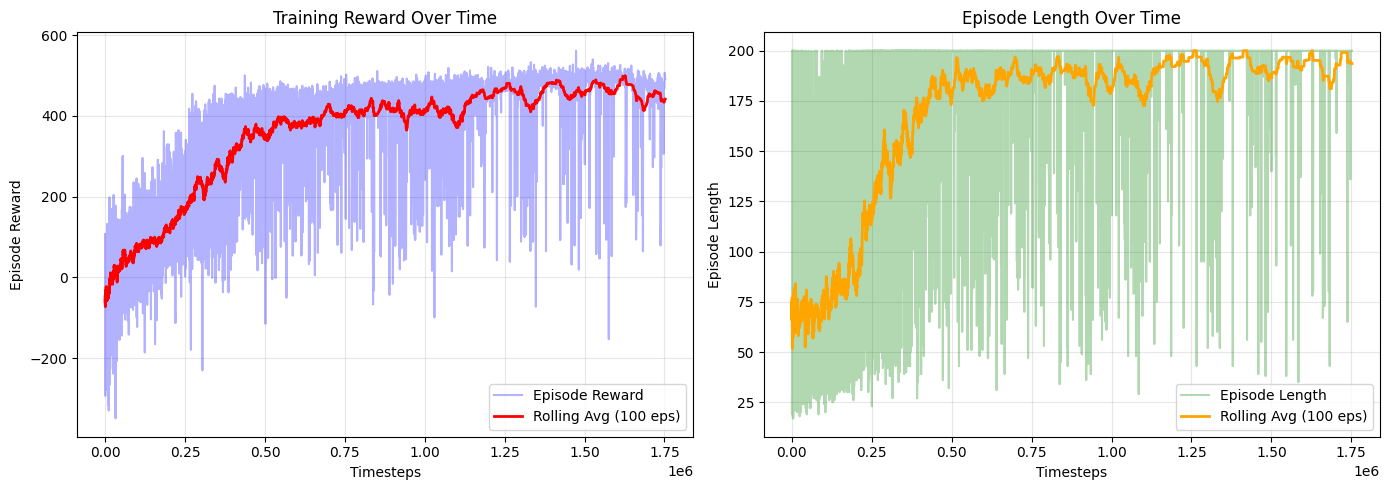

Training Summary:
Total episodes: 12044
Final avg reward (last 100 eps): 441.63
Max reward: 561.64
  Final avg length (last 100 eps): 193.6


In [7]:
standing_df = load_results(log_dir)
helpers.plot_training_progress(standing_df)
helpers.print_training_summary(standing_df)

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
C:\Users\326po\AppData\Local\Temp\ipykernel_29136\2101531400.py:1: SyntaxWarning: invalid escape sequence '\l'
  model = PPO.load("trained_models\lucy_v1_standing_model_2026-01-10_09-43.zip", env =make_env())


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


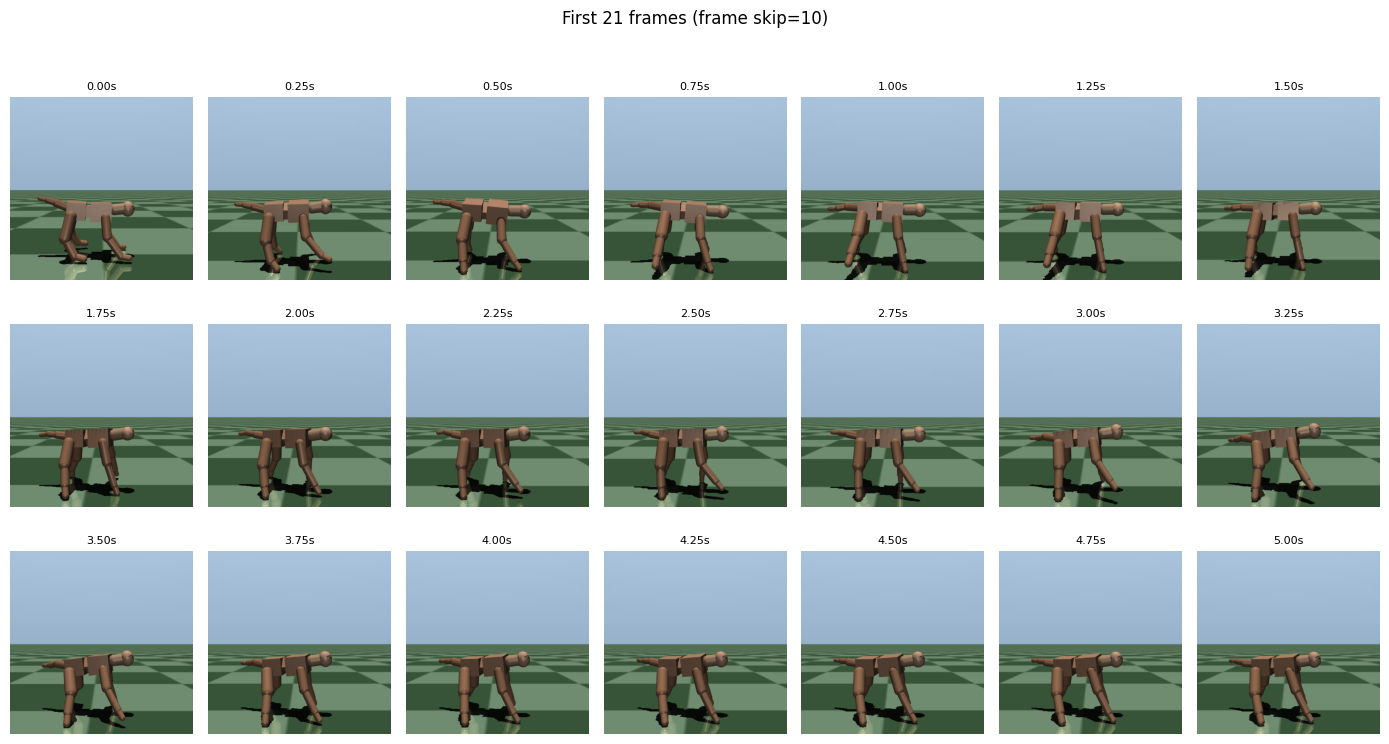

,time,chest_height,forward_velocity,height_reward,head_direction_reward,reward,cum_reward
0,0.00,NaN,NaN,None,NaN,NaN,NaN
1,0.25,0.229723,0.218329,None,0.090806,2.616253,22.915047
2,0.50,0.219555,-0.025976,None,0.096718,2.640001,49.347202
3,0.75,0.218084,0.125726,None,0.097921,2.629335,75.343165
4,1.00,0.224426,0.000103,None,0.098496,2.743041,102.371286
5,1.25,0.225815,-0.012090,None,0.097028,2.745193,129.959561
6,1.50,0.223408,-0.032477,None,0.096076,2.632812,156.779217
7,1.75,0.225910,-0.123566,None,0.067610,2.564882,183.003248
8,2.00,0.227942,0.029049,None,0.058813,2.715293,209.598510
9,2.25,0.231251,0.015969,None,0.061001,2.723422,236.705207


In [9]:
model = PPO.load("trained_models\lucy_v1_standing_model_2026-01-10_09-43.zip", env =make_env())
importlib.reload(render_model_gym)
df = render_model_gym.display_test_env(
    make_env(render_mode="rgb_array"),
    max_frames=21,
    frame_skip=10,
    attr_keys=[
        "chest_height",
        "forward_velocity",
        "height_reward",
        "head_direction_reward",
    ],
    model=model,
)
plt.show()
display(df)

# Walking training

<>:27: SyntaxWarning: invalid escape sequence '\l'
<>:27: SyntaxWarning: invalid escape sequence '\l'
C:\Users\326po\AppData\Local\Temp\ipykernel_29136\1574685520.py:27: SyntaxWarning: invalid escape sequence '\l'
  load_standing_model_path = "trained_models\lucy_standing_model_2026-01-09_22-32.zip"
Exception ignored in: <function OffScreenViewer.__del__ at 0x0000028036B61A80>
Traceback (most recent call last):
  File "c:\GitHub\training-lucy\.venv\Lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 234, in __del__
    self.free()
  File "c:\GitHub\training-lucy\.venv\Lib\site-packages\gymnasium\envs\mujoco\mujoco_rendering.py", line 231, in free
    self.opengl_context.free()
  File "c:\GitHub\training-lucy\.venv\Lib\site-packages\mujoco\glfw\__init__.py", line 37, in free
    glfw.destroy_window(self._context)
  File "c:\GitHub\training-lucy\.venv\Lib\site-packages\glfw\__init__.py", line 1281, in destroy_window
    _glfw.glfwDestroyWindow(window)
OSError: exception: a

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


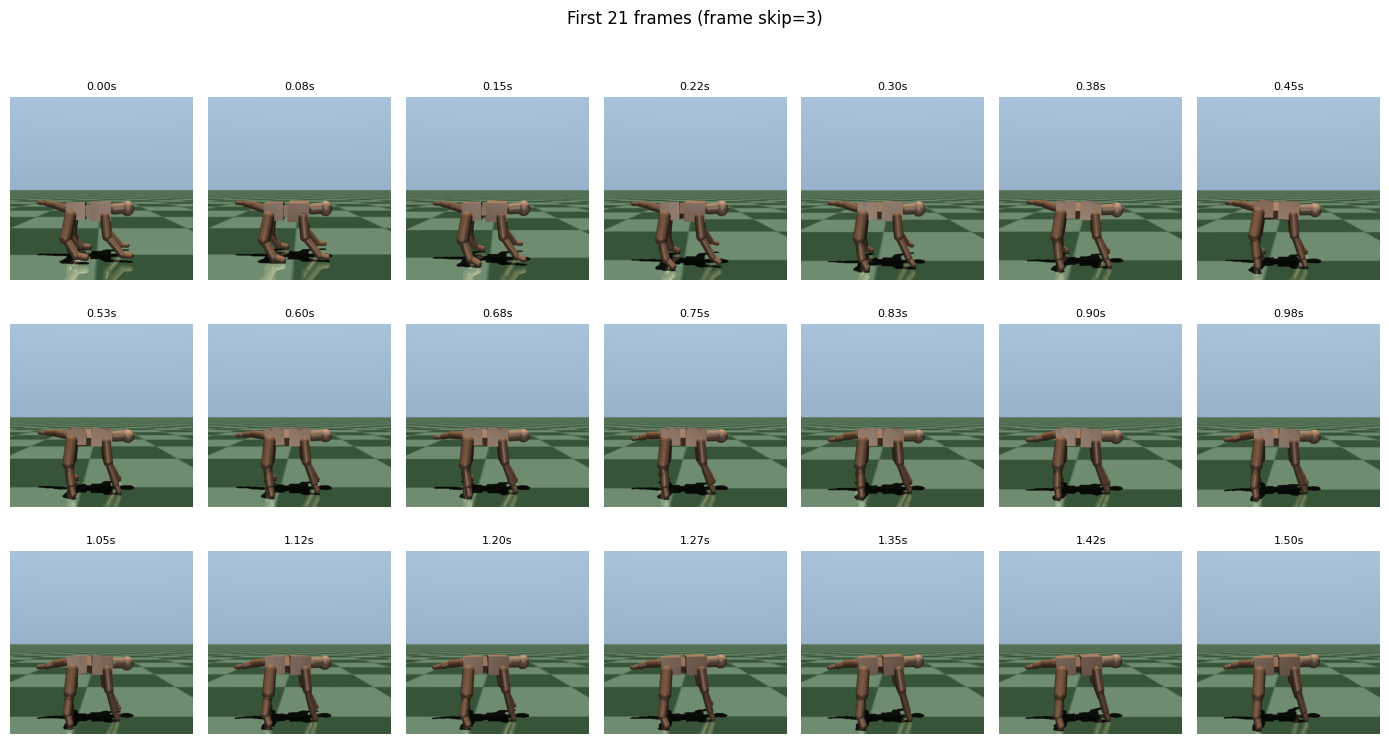

,time,chest_height,forward_velocity,forward_reward,gait_reward,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN
1,0.075,0.200565,0.071189,0.174514,0.0,1.139889,2.399762
2,0.150,0.215247,0.184074,0.385969,0.0,1.374973,6.308235
3,0.225,0.225680,0.222995,0.456252,0.0,1.467078,10.622021
4,0.300,0.229831,0.185311,0.365999,0.0,1.389772,14.960841
5,0.375,0.224542,0.223570,0.451886,0.0,1.466465,19.335137
6,0.450,0.226875,0.046407,0.063108,0.0,1.085331,22.910683
7,0.525,0.226950,-0.049237,-0.109676,-0.0,0.907769,25.794117
8,0.600,0.229031,0.006805,0.022892,0.0,1.043183,28.767965
9,0.675,0.230025,0.030325,0.074904,0.0,1.097941,32.016961


In [34]:
# Create walking training environment
importlib.reload(lucy)


walking_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
walking_log_dir = f"logs/lucy_walking_{walking_start_time}/"
os.makedirs(walking_log_dir, exist_ok=True)


def make_walking_env(render_mode="None"):
    """Factory function for walking environment."""
    env = lucy.LucyEnv(
        xml_file=xml_path,
        render_mode=render_mode,
        max_episode_seconds=20,
    )
    env = lucy.LucyWalkingWrapper(
        env,
        forward_weight=2.0,
        gait_weight=0.2,
        ctrl_cost_weight=0.001,
        body_contact_penalty=-2.0,
    )
    return env


load_standing_model_path = "trained_models\lucy_standing_model_2026-01-09_22-32.zip"

env = make_walking_env(render_mode="rgb_array")  # your factory
model = PPO.load(load_standing_model_path, env=env)  # or walking model path
model.set_env(env)  # attach env so model.predict works
df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=[        "chest_height",
        "forward_velocity",
        "forward_reward",
        "gait_reward",],
    model=model,
)
plt.show()
df

In [23]:
walking_vec_env = make_vec_env(
    make_walking_env,
    n_envs=n_envs,
    vec_env_cls=SubprocVecEnv,
    monitor_dir=walking_log_dir,
)
walking_vec_env = VecMonitor(walking_vec_env, walking_log_dir)


standing_model_save_path = "trained_models\ppo_lucy_standing_2026-01-09_21-52.zip"
walking_model = PPO.load(standing_model_save_path, env = walking_vec_env)
walking_model.set_env(walking_vec_env)   # attach walking env


walking_model.learn(total_timesteps=1_000_000)

<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
C:\Users\326po\AppData\Local\Temp\ipykernel_29136\2347212836.py:10: SyntaxWarning: invalid escape sequence '\p'
  standing_model_save_path = "trained_models\ppo_lucy_standing_2026-01-09_21-52.zip"
c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | 100      |
| time/              |          |
|    fps             | 2353     |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 108         |
|    ep_rew_mean          | 101         |
| time/                   |             |
|    fps                  | 2173        |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.018507501 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -27.5       |
|    explained_variance   | 0.745       |
|    learning_rate        | 0.

In [25]:
walking_model_path = os.path.join(PROJECT_ROOT, "trained_models", f"lucy_v1_walking_model_{walking_start_time}")
walking_model.save(walking_model_path)

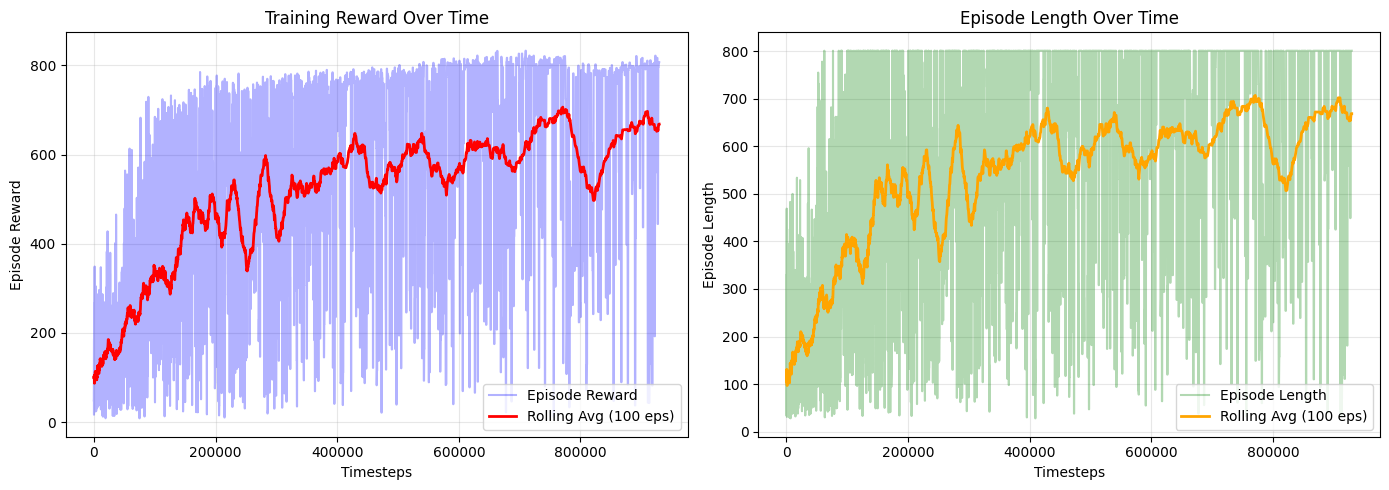

Training Summary:
Total episodes: 5052
Final avg reward (last 100 eps): 668.32
Max reward: 833.15
  Final avg length (last 100 eps): 668.6


In [27]:
# Plot walking training progress
walking_df = load_results(walking_log_dir)
helpers.plot_training_progress(walking_df)
helpers.print_training_summary(walking_df)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


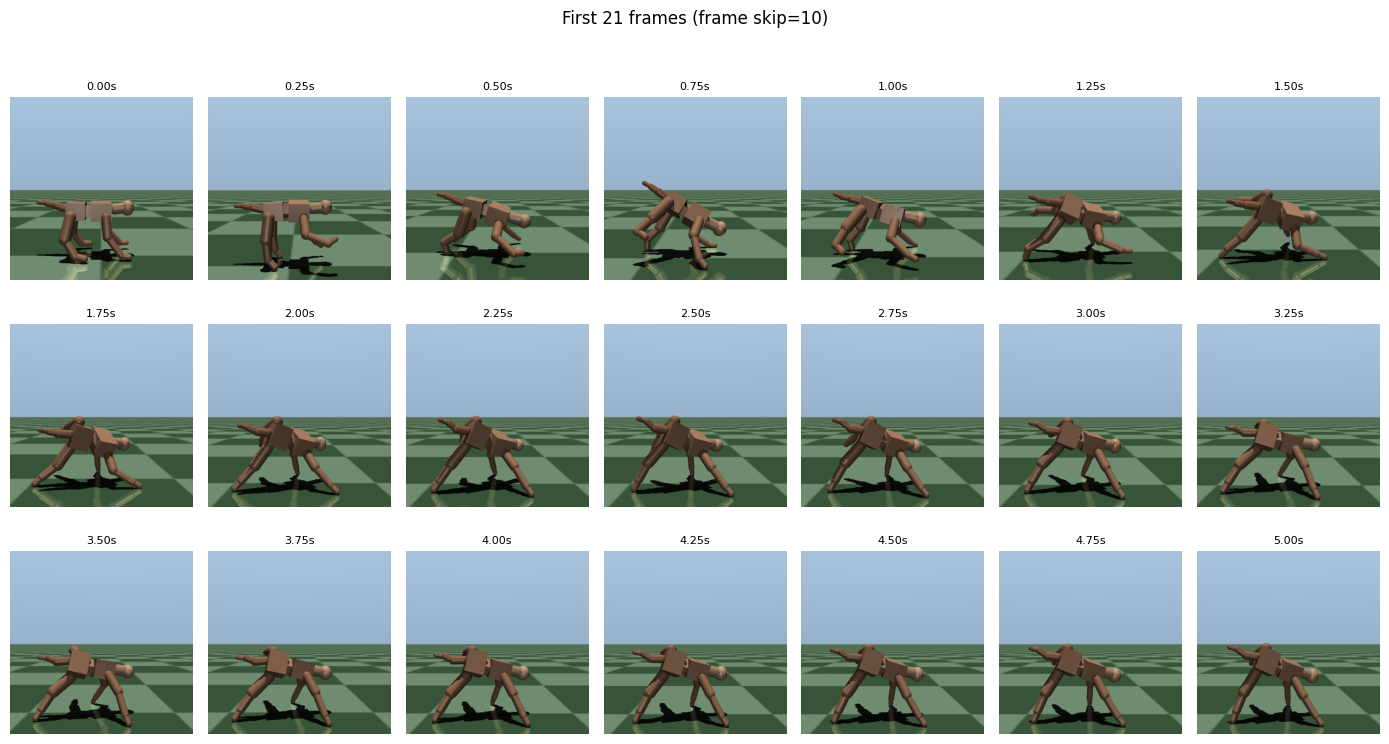

,time,chest_height,forward_velocity,forward_reward,gait_reward,reward,cum_reward
0,0.00,NaN,NaN,None,None,NaN,NaN
1,0.25,0.241980,0.354254,None,None,2.842559,19.544318
2,0.50,0.172045,0.712090,None,None,2.202561,46.936043
3,0.75,0.166916,-0.003096,None,None,0.178687,58.051065
4,1.00,0.181561,0.065210,None,None,2.300535,70.514889
5,1.25,0.179394,0.455496,None,None,2.234184,93.879783
6,1.50,0.178151,0.055520,None,None,2.173598,111.584366
7,1.75,0.183905,-0.047958,None,None,2.174871,133.062650
8,2.00,0.196885,-0.041623,None,None,2.416545,156.083512
9,2.25,0.194956,0.006223,None,None,2.488799,180.735519


In [37]:
model = PPO.load(walking_model_path, env =make_env())
importlib.reload(render_model_gym)
df = render_model_gym.display_test_env(
    make_env(render_mode="rgb_array"),
    max_frames=21,
    frame_skip=10,
    attr_keys=[
"chest_height",
        "forward_velocity",
        "forward_reward",
        "gait_reward",
    ],
    model=model,
)
plt.show()
display(df)

In [30]:
render_model_gym.render_model_gym(walking_model_path, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Simulation dt: 0.0250s per step
Running simulation at 1.0x speed... Close the window to exit.

Stopped by user
